In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

In [43]:
data_dir='levelups_panel_0920_filled.csv'
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
0,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
1,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
2,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
3,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
4,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720616,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720617,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720618,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720619,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [44]:
data['event_datetime']

0         2021-11-01 19:16:29
1         2021-11-01 19:16:43
2         2021-11-01 19:17:16
3         2021-11-01 19:18:12
4         2021-11-01 19:19:06
                 ...         
720616    2022-03-30 18:15:40
720617    2022-03-30 18:15:50
720618    2022-03-30 18:18:40
720619    2022-03-30 18:22:59
720620    2022-03-30 18:27:24
Name: event_datetime, Length: 720621, dtype: object

In [45]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'], errors='coerce')

data['time_diff'] = data.groupby('player_slug')['event_datetime'].diff().shift(-1)

# 2시간 이상의 차이가 나는 경우를 필터링 (2시간은 2 * 60 * 60 초)
three_hours = pd.Timedelta(hours=2)
data['more_than_3_hours'] = data['time_diff'] > three_hours
data['total_num_played'] = data.groupby('player_slug')['more_than_3_hours'].transform('sum')


In [46]:
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,time_diff,more_than_3_hours,total_num_played
0,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0 days 00:00:14,False,3
1,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0 days 00:00:33,False,3
2,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0 days 00:00:56,False,3
3,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0 days 00:00:54,False,3
4,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0 days 00:01:14,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720616,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0,0 days 00:00:10,False,0
720617,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0,0 days 00:02:50,False,0
720618,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0,0 days 00:04:19,False,0
720619,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0,0 days 00:04:25,False,0


In [50]:
single_day_data=data[data['total_num_played']==0]
multi_day_data=data[data['total_num_played']!=0]

In [48]:
num=single_day_data['player_slug'].nunique()
num

1865

In [51]:
multi_day_data['player_slug'].nunique()

5414

## 플레이 시간 비교

In [52]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot'] = multi_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
multi_day_data['interval_normalized'] = multi_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until_norm'] = multi_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot_norm'] = multi_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_multi = multi_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\657298615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\657298615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\657298615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [53]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot'] = single_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
single_day_data['interval_normalized'] = single_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until_norm'] = single_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot_norm'] = single_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_single = single_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\3484137446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\3484137446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_21464\3484137446.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [54]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg = df_last_single['interval_tot'].mean()

# 결과 출력
print(interval_avg)


3.478782246053019


In [55]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg_multi = df_last_multi['interval_tot'].mean()

# 결과 출력
print(interval_avg_multi)


4.328776967122271


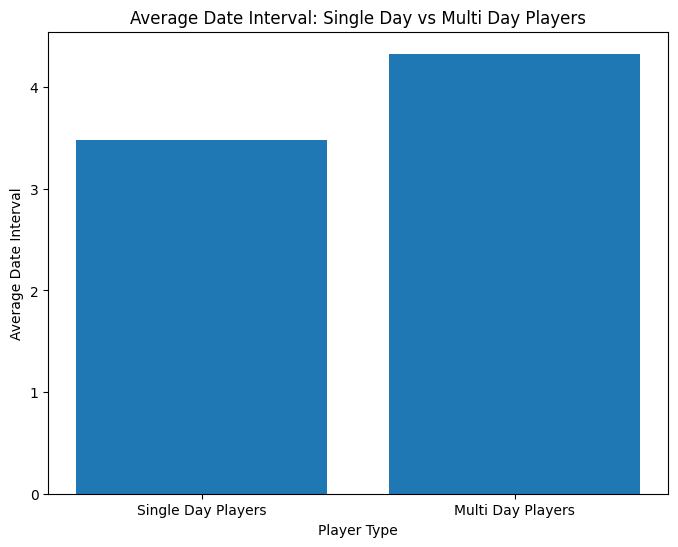

In [56]:
import matplotlib.pyplot as plt

# 두 그룹의 평균 값
intervals = [interval_avg, interval_avg_multi]
labels = ['Single Day Players', 'Multi Day Players']

# 바 플롯 생성
plt.figure(figsize=(8, 6))
plt.bar(labels, intervals)

# 플롯 라벨과 제목 설정
plt.xlabel('Player Type')
plt.ylabel('Average Date Interval')
plt.title('Average Date Interval: Single Day vs Multi Day Players')

# 그래프 출력
plt.show()


## 2시간 이상 간격이 몇번 있었는지

In [60]:
# 'date_event'가 하루만 있는 사람들을 찾기 위해 각 player_slug에 대해 date_event의 고유 값 개수를 계산
thr_hours = data.groupby('player_slug')['total_num_played'].unique()
frequency_counts = thr_hours.value_counts()
frequency_counts


total_num_played
[0]     1865
[1]     1813
[2]     1305
[3]      887
[4]      526
[5]      301
[6]      200
[7]      107
[8]       90
[9]       55
[10]      35
[11]      25
[12]      19
[13]      16
[16]       6
[14]       5
[17]       5
[15]       4
[19]       2
[21]       2
[22]       2
[18]       2
[20]       2
[41]       1
[23]       1
[25]       1
[26]       1
[36]       1
Name: count, dtype: int64

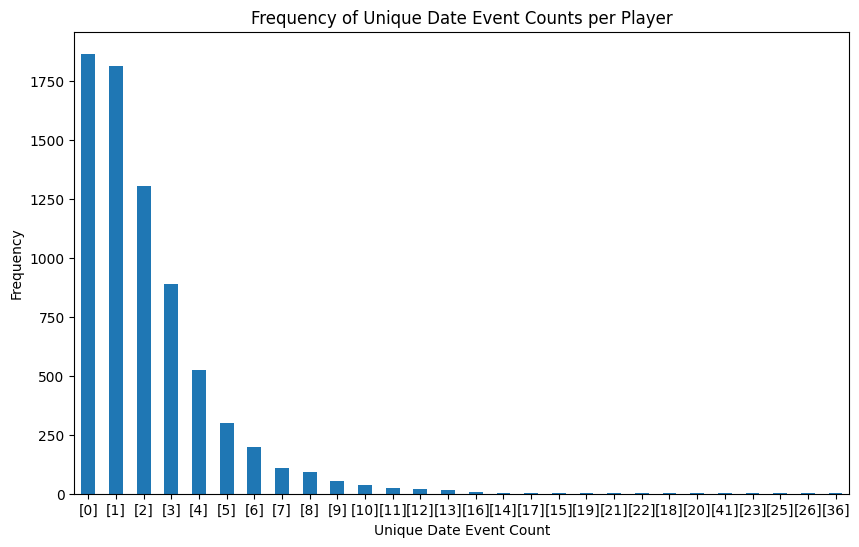

In [64]:
# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Frequency of Unique Date Event Counts per Player')
plt.xlabel('Unique Date Event Count')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# 그래프 출력
plt.show()